<center><font size="6"><b>CV SEGA</b></font></center>
<p></p>
<center><font size="5"><b>Modélisation pour détection des bennes</b></font></center>
<br>
<br>
<br>

# Intentions

Détecter et entourer les bennes via des bounding box.

# Versions

Voir CV_SEGA_model_objdetect_versions.md


# Configuration du notebook

In [23]:
# Mode d'éxécution du notebook : "drive" ou "local"
work_mode = "drive"

# Localisation des modèles pour les sauvegardes et les chargements
if work_mode == "drive":
    model_loc = "/drive/My Drive/CV_DS/..."
elif work_mode == "local":
    model_loc = "_models"

In [24]:
%%javascript
// Récupération du nom du notebook
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [25]:
# Récupération du nom notebook pour les sauvegardes de modèles et connection au drive et montage du drive
if work_mode == "drive":
    # Montage du drive
    from requests import get
    theNotebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    theNotebook = theNotebook[0:-6]
    print("Nom du notebook : ",theNotebook)
    
    # Montage du drive
    from google.colab import  drive
    drive.mount('/content/drive',force_remount=True)

Nom du notebook :  CV_SEGA_model_objdetect_5
Mounted at /content/drive


# Installer

In [26]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [27]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Using cached tensorflow-2.9.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1694828 sha256=ae4feb6c7faed7ef079df0a166299a1c29e3be0972e305596ed3c7254c17db09
  Stored in directory: /tmp/pip-ephem-wheel-cache-zzluse_p/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling ker

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [6]:
if work_mode == "drive":
    # Install right version tensorflow and fiftyone
    !pip install tensorflow==2.7.0
    !pip install opencv-python-headless==4.5.4.60 fiftyone
    !pip install fiftyone --no-binary fiftyone,voxel51-eta
    # Restart the runtime
    import os
    os.kill(os.getpid(), 9)


# Modules et fonctions

## Import des modules


In [28]:
# Classics
import pandas as pd
import numpy as np
import random

# Opérations sur fichiers/dossiers
import os
from joblib import load, dump
import json
from glob import glob

# Viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import missingno as msno
%matplotlib inline

# Autres
from tqdm import tqdm
from collections import Counter
import pprint

# Tensorflow
import tensorflow as tf

# Preprocess
from sklearn.model_selection import train_test_split


## La cuisine

## Test GPU

In [29]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
sys_details = tf.sysconfig.get_build_info()
if tf.test.gpu_device_name():
    device_name = tf.test.gpu_device_name()
    print(f'GPU found : {device_name}')
    pprint.print(sys_details)
else:
    tf.config.list_physical_devices('CPU')
    print("No GPU found, CPU mode activated")
    pprint.pprint(sys_details)

No GPU found, CPU mode activated
OrderedDict([('cpu_compiler', '/usr/bin/x86_64-linux-gnu-gcc-7'),
             ('cuda_compute_capabilities',
              ['compute_37',
               'compute_60',
               'compute_61',
               'compute_70',
               'compute_75',
               'compute_80']),
             ('cuda_version', '11.1'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', False)])


# Chargement du dataset

## Bennes

In [30]:
# Lecture des données
if work_mode == "local":
    data_path = "Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/container"
#     data_path = "E:/OneDrive/_forge/SEGA/datasets/container"
elif work_mode == "drive":
    data_path = "drive/My Drive/CV_DS/_data/container"

df = pd.read_csv(data_path + '/df_1.csv',index_col=0,converters={'bbox': pd.eval})
df = df.astype({'file_name':'string'})
df["file_name"] = df["file_name"].apply(lambda x: data_path + "/" + x)
display (df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1483 entries, 0 to 1482
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       1483 non-null   object 
 1   file_extension  1483 non-null   object 
 2   id              1483 non-null   int64  
 3   width           1483 non-null   int64  
 4   height          1483 non-null   int64  
 5   channel         1483 non-null   int64  
 6   segmentation    1483 non-null   object 
 7   area            1483 non-null   int64  
 8   bbox            1483 non-null   object 
 9   use             1483 non-null   object 
 10  bbox_area       1483 non-null   float64
 11  bright          1483 non-null   float64
 12  lumin           1483 non-null   float64
 13  lapla           1483 non-null   float64
 14  expos           1483 non-null   object 
dtypes: float64(4), int64(5), object(6)
memory usage: 185.4+ KB


None

,file_name,file_extension,id,width,height,channel,segmentation,area,bbox,use,bbox_area,bright,lumin,lapla,expos
0,drive/My Drive/CV_DS/_data/container/00001.jpeg,jpeg,1,566,291,3,"[[10, 39, 45, 31, 53, 32, 53, 41, 66, 42, 65, ...",154615,"[10, 0, 535, 289]",train,93.87,0.59,0.195979,0.015235,ok
1,drive/My Drive/CV_DS/_data/container/00002.jpeg,jpeg,2,500,375,3,"[[18, 64, 133, 46, 418, 79, 409, 199, 393, 208...",89600,"[18, 46, 400, 224]",train,47.79,0.49,0.163998,0.001462,ok
2,drive/My Drive/CV_DS/_data/container/00003.jpeg,jpeg,3,762,764,3,"[[1, 292, 570, 51, 622, 186, 655, 188, 654, 22...",426018,"[1, 51, 703, 606]",train,73.18,0.43,0.143152,0.009925,ok
3,drive/My Drive/CV_DS/_data/container/00004.jpeg,jpeg,4,820,429,3,"[[11, 168, 10, 170, 13, 342, 0, 350, 4, 376, 1...",141491,"[0, 135, 493, 287]",train,40.22,0.38,0.126186,0.009897,ok
4,drive/My Drive/CV_DS/_data/container/00004.jpeg,jpeg,4,820,429,3,"[[557, 81, 789, 77, 788, 93, 779, 95, 781, 107...",43338,"[556, 77, 233, 186]",train,12.32,0.38,0.126186,0.009897,ok


En effet, dans le format CoCo, la colonne bbox correspond aux coordonnées  𝑥𝑚𝑖𝑛 ,  𝑦𝑚𝑖𝑛 ,  𝑤  et  ℎ  non normalisées, c'est-à-dire dans l'echelle des pixels.

Alors que le format demandé par les modèles de tensorflow est le suivant : $y_{min}$, $x_{min}$, $y_{max}$ et $x_{max}$ normalisés.

In [31]:
# Normalisation des coordonnées de BB
def convertWHXY_normalized(x):
    bbox = x['bbox']
    w = x['width']
    h = x['height']
    return [bbox[1]/h, bbox[0]/w, (bbox[1]+bbox[3])/h, (bbox[0]+bbox[2])/w]

df['bbox_normilized'] = df[["height", "width", "bbox"]].apply(convertWHXY_normalized, axis=1)

# Création de la colonne category_id
df["category_id"]=1

In [32]:
df.head()

,file_name,file_extension,id,width,height,channel,segmentation,area,bbox,use,bbox_area,bright,lumin,lapla,expos,bbox_normilized,category_id
0,drive/My Drive/CV_DS/_data/container/00001.jpeg,jpeg,1,566,291,3,"[[10, 39, 45, 31, 53, 32, 53, 41, 66, 42, 65, ...",154615,"[10, 0, 535, 289]",train,93.87,0.59,0.195979,0.015235,ok,"[0.0, 0.0176678445229682, 0.993127147766323, 0...",1
1,drive/My Drive/CV_DS/_data/container/00002.jpeg,jpeg,2,500,375,3,"[[18, 64, 133, 46, 418, 79, 409, 199, 393, 208...",89600,"[18, 46, 400, 224]",train,47.79,0.49,0.163998,0.001462,ok,"[0.12266666666666666, 0.036, 0.72, 0.836]",1
2,drive/My Drive/CV_DS/_data/container/00003.jpeg,jpeg,3,762,764,3,"[[1, 292, 570, 51, 622, 186, 655, 188, 654, 22...",426018,"[1, 51, 703, 606]",train,73.18,0.43,0.143152,0.009925,ok,"[0.06675392670157068, 0.0013123359580052493, 0...",1
3,drive/My Drive/CV_DS/_data/container/00004.jpeg,jpeg,4,820,429,3,"[[11, 168, 10, 170, 13, 342, 0, 350, 4, 376, 1...",141491,"[0, 135, 493, 287]",train,40.22,0.38,0.126186,0.009897,ok,"[0.3146853146853147, 0.0, 0.9836829836829837, ...",1
4,drive/My Drive/CV_DS/_data/container/00004.jpeg,jpeg,4,820,429,3,"[[557, 81, 789, 77, 788, 93, 779, 95, 781, 107...",43338,"[556, 77, 233, 186]",train,12.32,0.38,0.126186,0.009897,ok,"[0.1794871794871795, 0.6780487804878049, 0.613...",1


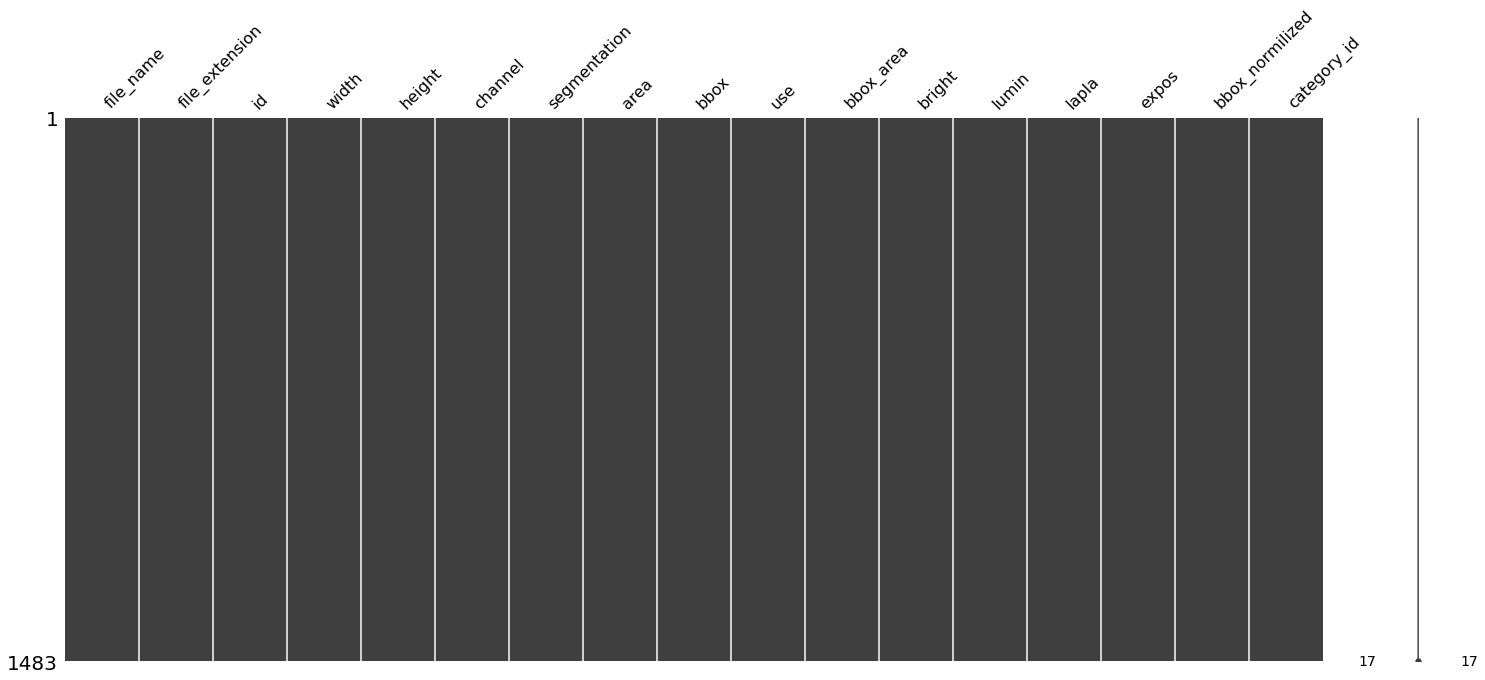

In [33]:
msno.matrix(df);

In [34]:
df_group = df.groupby("id").agg({"file_name":"min",
                                 "file_extension":"count",
                                 "height":"min",
                                 "width":"min",
                                 "bbox_normilized":list,
                                 "category_id":list})
df_group.rename(columns={'file_extension': 'occurence'}, inplace = True)
df_group.head()

,file_name,occurence,height,width,bbox_normilized,category_id
id,,,,,,
1,drive/My Drive/CV_DS/_data/container/00001.jpeg,1,291,566,"[[0.0, 0.0176678445229682, 0.993127147766323, ...",[1]
2,drive/My Drive/CV_DS/_data/container/00002.jpeg,1,375,500,"[[0.12266666666666666, 0.036, 0.72, 0.836]]",[1]
3,drive/My Drive/CV_DS/_data/container/00003.jpeg,1,764,762,"[[0.06675392670157068, 0.0013123359580052493, ...",[1]
4,drive/My Drive/CV_DS/_data/container/00004.jpeg,3,429,820,"[[0.3146853146853147, 0.0, 0.9836829836829837,...","[1, 1, 1]"
5,drive/My Drive/CV_DS/_data/container/00005.jpeg,2,150,240,"[[0.3, 0.004166666666666667, 0.893333333333333...","[1, 1]"


## Stanford BG

On ajoute ici le dataset stanford background afin d'assurer la fonction de détection d'objets. Le modèle pourra ainsi fournir une sortie avec l'information de la présence ou de l'absence de benne.

In [14]:
# # Return all path in folder iccv09Data with .jpg extention
# # backgrounds_dir = 'E:/OneDrive/_forge/SEGA/datasets/stanford_background/'
# backgrounds_dir = "Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/stanford_background/"
# background_image_files = glob(backgrounds_dir +'**.jpg')

# # load images in background_image list
# background_image = []
# for p in tqdm(background_image_files):
#     img = plt.imread(p)
#     background_image.append(img)

# len(background_image)

In [15]:
# plt.figure(figsize=(12,5))
# for j, im in enumerate(random.sample(background_image, 8)):
#     plt.subplot(2,4,j+1)
#     plt.axis('off')
#     plt.imshow(im)

## Visualisation

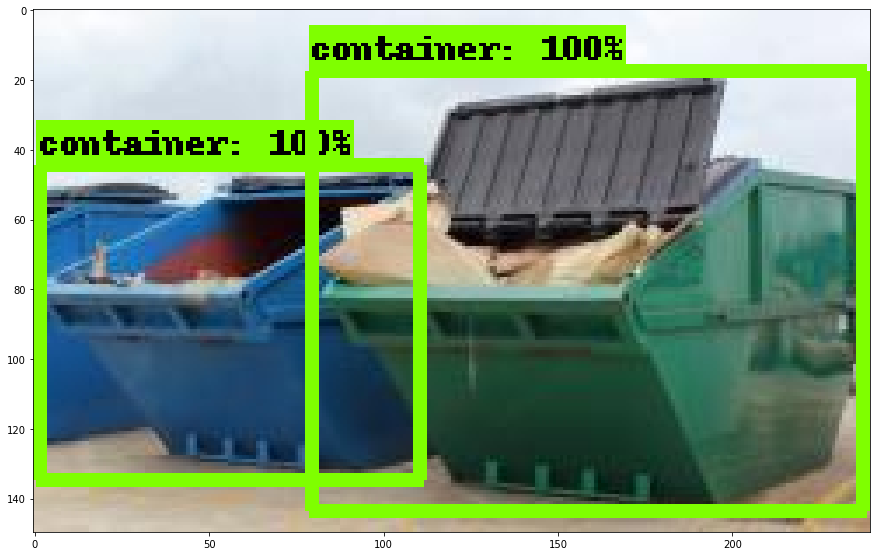

In [35]:
%matplotlib inline
from object_detection.utils import visualization_utils as viz_utils
import matplotlib.pyplot as plt
from object_detection.utils import label_map_util
import numpy as np
import cv2

# Define relation index/name object
category_index = {0: {'id': 0, 'name': 'bg'}, 1: {'id': 1, 'name': 'container'}}
# category_index = dict(list(zip(list(map(lambda x : x['id'], data['categories'])), data['categories'])))

# Select a observation
idx = 4
observation = df_group.iloc[idx]

# Load the image and convert it into RGB
img = cv2.imread(observation["file_name"])[..., ::-1]


# Overwrite the image to add annotation
image_np_with_detections = img.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      np.array(observation["bbox_normilized"]),
      np.array(observation["category_id"]),
      np.ones(len(observation["category_id"])),
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=.30)

# Show image annoted
plt.figure(figsize=(15,20))
plt.imshow(image_np_with_detections)
plt.show()

## Générateur

In [36]:
import tensorflow as tf
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size,
                 nb_class = 2,
                 input_size=(128, 128, 3),
                 shuffle=True):
        
        self.df = df.copy()
        self.batch_size = batch_size
        self.nb_class = nb_class
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
    
    def __get_input(self, path, target_size):
        # Load the image
        image = tf.keras.preprocessing.image.load_img(path)
        # Convert to array
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        # resize it
        image_arr = tf.image.resize(image_arr, (target_size[0], target_size[1])).numpy()
        
        return image_arr
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    

    def __getitem__(self, index):
        # Select the batch of data
        batches = self.df.iloc[index * self.batch_size: (index + 1) * self.batch_size]

        X_batch = []
        # Load images  
        for path in batches["file_name"] :
            im = self.__get_input(path, target_size=self.input_size)
            X_batch.append(im)

        # Coordinate label
        gt_box_tensors =[gt_box_np for gt_box_np in batches['bbox_normilized']]

        # Class Label
        gt_classes_one_hot_tensors = [tf.one_hot(gt_label_np, self.nb_class).numpy() for gt_label_np in batches['category_id']]
    
        return np.array(X_batch), gt_box_tensors, gt_classes_one_hot_tensors
    
    def __len__(self):
        return self.n // self.batch_size
    
batch_size = 8
dataTrain = DataGenerator(df_group, batch_size=batch_size)


# Modélisation



> Pour rappel, l'API de tensorflow propose une liste exhaustive de modèles pré-entraînés : https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
>
>
> <img src='_assets/object_detection_dl_model.png' style='width:300px'>
><center> <b> Figure :</b> Liste des modèles disponibles sur l'<a href="https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md"> API de tensorflow</a> </center>
>
>
> Les colonnes du tableau correspondent : 
>
> * **Model name** : Indicant le type de modèles utilisés (Yolo, R-CNN, SSD...), le backbone utilisé et la taille d'entrée des données. Le lien permet de télécharger le modèle.
>
> * **Speed** : Vitesse d'inférence sur une machine spécifique.
>
>
>* **COCO mAP** : Performance du modèle sur le jeu de donnée COCO.
>
>
>* **Outputs** : Type de prédiction du modèle.
>
>
> Pour utiliser le modèle, il sera nécessaire de mettre le checkpoint du modèle dans le dossier *models/research/object_detection/test_data*.

* **(a)** Exécuter la cellule suivante pour télécharger un des modèles, décompresser et placer le checkpoint dans le bon dossier.

In [38]:
# Download the checkpoint and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-07-04 22:17:58--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   189MB/s    in 1.2s    

2022-07-04 22:18:00 (189 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’ saved [244817203/244817203]



> Pour facilité l'utisation des modèles, l'api de détection d'objet de tensorflow utilise des **pipelines** contenant : le **prétraitement des données**, un système d'**augmenatation de données**, le **modèle** et les **fonctions de pertes**, ainsi que le **post traitement** avec la non max suppression.
>
> Les configurations des modèles se trouvent dans le dossier "models/research/object_detection/configs/tf2/".

* **(b)** Exécuter la cellule suivante pour charger le fichier config de notre modèle téléchagé plus haut.

In [39]:
from object_detection.utils import config_util
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
# Load the config model, and override it to adapt it on the case
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
configs

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
   

> Il est très facile de changer le fichier config pour l'adapter à notre tâche.

* **(c)** Exécuter la cellule suivante pour changer quelques éléments dans le dictionnaire de config.

In [40]:
num_classes = 2

# Override it to adapt it on the case
model_config = configs['model']
# Override the numbrer of class
model_config.ssd.num_classes = num_classes
# Freeze the batchnorm layer in fine tuning.
model_config.ssd.freeze_batchnorm = True

> La fonction `build` de **`model_builder`** permet de construire le modèle en fonction fichier **`model_config`**.

* **(d)** Exécuter la cellule suivante pour constuire notre modèle sous le nom **`detection_model`**.

In [41]:
from object_detection.builders import model_builder
import tensorflow as tf

# Clear all state in tensorflow
tf.keras.backend.clear_session()

# Build the model
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

In [42]:
print('Restoring weights for fine-tuning...', flush=True)

checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Checkpoint for box predictor
ckpt_box_predictor = tf.compat.v2.train.Checkpoint(
    # Restore the base head
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # Restore the classification head
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    # Restore the regression head
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )

# Checkpoint for the model
ckpt_model = tf.compat.v2.train.Checkpoint(
          # Restore the backbone
          _feature_extractor=detection_model._feature_extractor,
          # Box predictor checkpoint
          _box_predictor=ckpt_box_predictor)

# Checkpoint for the final model
ckpt = tf.compat.v2.train.Checkpoint(model=ckpt_model)

# Restore the weight of the model
ckpt.restore(checkpoint_path).expect_partial()


# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

print('Weights restored!')

Restoring weights for fine-tuning...
Weights restored!


> Maintenant que le modèle est chargé, entrainons le sur notre tâche.

### Variables à Fine tune

> Pour fine tune un modèle pré-entraîné, il est coutume de freeze les couches d'extraction de caractéristiques (backbone...).
>
> C'est pourquoi, nous allons faire le choix d'entraîner uniquement la tête de détection ainsi que la tête de classification.


* **(f)** Exécuter la cellule suivante pour stocker toutes les variables à entraîner dans la liste **`to_fine_tune`**.

In [43]:
tf.keras.backend.set_learning_phase(True)

# Select trainable variables.
trainable_variables = detection_model.trainable_variables

prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

to_fine_tune = []
# Select each variable with a prefixe from prefixes_to_train
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  


### Fonction d'entraînement

>  Pour rappel, tensorflow permet de personaliser tout le processus d'entraînement :
>
>```python
># Record every operation in GradientTape
>with tf.GradientTape() as tape:
>    # Model prediction.
>    y_pred = model(X)
>    # Compute the loss function.
>    loss_value = loss(y_true, y_pred)
>
># Compute the gradient function thanks to GradientTape
>grads = tape.gradient(loss_value, parameters_to_train)
>
># Update the weights of the model.
>optimizer.apply_gradients(zip(grads, parameters_to_train))
>```
>
>Ici, commme **`detection_model`** est un pipeline, il est dôté des méthodes suviantes : 
>
> * `preprocess` : Normalise des images du lot de données.
>
>
> * `predict` : Prédit sour le format de dictionnaire les sorties du modèle
>
>
> * `provide_groundtruth` : Fournit la vraie cible au modèle. Indispensable pour calculer la fonction de perte `loss`.
>
>
> * `loss` : Prédit sous le format de dictionnaire les valeurs des différentes fonctions de perte renseignées dans le fichier config. Ici, les valeurs des clés 'Loss/localization_loss' et 'Loss/classification_loss' correspondent respectivement à la fonction de perte de localisation et de classification.

* **(g)** Exécuter la cellule suivante pour définir notre fonction d'entraînement

In [44]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    # @tf.function
    def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
        """A single training iteration.

        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth boxes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        # Shape of images
        shapes = tf.constant(batch_size * [[128, 128, 3]], dtype=tf.int32)

        

        # Give true target  to the model
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        
        with tf.GradientTape() as tape:
            # Prepross input adaptative to different shape of images
            preprocessed_images = tf.concat(
              [detection_model.preprocess(tf.expand_dims(image_tensor,0))[0]
               for image_tensor in image_tensors], axis=0)
            # preprocessed_images = detection_model.preprocess(tf.convert_to_tensor(image_tensors, tf.float32))
            # Predict values
            prediction_dict = model.predict(preprocessed_images, shapes)
            # Compute losses
            losses_dict = model.loss(prediction_dict, shapes)
            # Extract localization_loss and classification_loss
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Compute the gradient
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        # Apply Back propagation
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn


> Maintenant que le modèle est défini, chargé et que la fonction d'entraînement est défini, il ne reste plus qu'à entraîner le modèle.

* **(h)** Exécuter la cellule suivante pour entraîner le modèle.

In [45]:
from tqdm import tqdm
EPOCHS = 2
learning_rate = 0.001

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Training function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Train the model
for i in range(EPOCHS):
    for image_tensors, gt_boxes_list, gt_classes_list in tqdm(dataTrain) :
        # Convert localisation of box to tensor
        gt_boxes_list =[tf.convert_to_tensor(gt_box_np, dtype=tf.float32) for gt_box_np in gt_boxes_list]
        # Convert class of box to tensor
        gt_classes_list =[tf.convert_to_tensor(gt_class_np, dtype=tf.float32) for gt_class_np in gt_classes_list]
        # print(image_tensors)
        # print(len(gt_boxes_list))
        # print(len(gt_classes_list))
        # Compute the training function
        total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
    # Show the loss of the last batch
    print('Epoch ' + str(i) + ', loss=' +  str(total_loss.numpy()), flush=True)

100%|██████████| 143/143 [1:37:59<00:00, 41.12s/it]

Epoch 0, loss=0.45772666



100%|██████████| 143/143 [1:31:13<00:00, 38.28s/it]

Epoch 1, loss=0.42665714


> Le modèle est maintenant entraîné, il ne reste plus qu'à définir le processus d'inférence. Pour obtenir le même résultat qu'un modèle d'inférence, il sera nécessaire de :
> * 1. **Prétraiter** l'image d'entrée : normalisation
>
>```python
>preprocessed_image, shapes = detection_model.preprocess(input_tensor)
>```
>
>
> * 2. **Prédire les objets** dans l'image
>
>```python
>prediction_dict = detection_model.predict(preprocessed_image, shapes)
>```
>
>
> 3. **Post-traiter** la sortie du modèle : non maximum suppresion
>
>```python
>prediction_final_dict = detection_model.postprocess(prediction_dict, shapes)
>```

* **(i)** Exécuter la cellule suivante pour définir la fonction `detection` ainsi qu'afficher la sortie pour une des images de notre jeu de données.

In [46]:
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(tf.convert_to_tensor(input_tensor, tf.float32))
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

detect(np.expand_dims(img, 0))

{'detection_anchor_indices': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
 array([[51078, 50616, 50719, 48681, 51043, 50607, 50725, 50753, 50599,
         49225, 50546, 49717, 49087, 50794, 49333, 50847, 50685, 50832,
         48973, 48684, 48523, 50706, 41367, 50487, 50655, 50621, 48993,
         50784, 49573, 50533, 50538, 42739, 50666, 43277, 49005, 46377,
         50748, 50856, 43119, 49699, 49897, 49209, 50478, 49601, 50628,
         49340, 49873, 43711, 49332, 49161, 15246, 48560, 50549, 41061,
         48642, 49183, 50682, 42019, 48449, 49237, 51132, 49741, 50600,
         48747, 50632, 48435, 42985, 50684, 50631, 49110, 41780, 50492,
         43465, 49220, 48563, 50732, 13479, 36105, 49446, 36075, 48798,
         41435, 49023, 44866, 41125, 44031, 50919, 26873, 16600, 50689,
         50726, 42581, 42162, 29097, 49232, 49100, 49871, 44193, 49967,
         49313]], dtype=int32)>,
 'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
 array([[[2.15810597e-01,

* **(j)** Exécuter la cellule suivante pour afficher la prédiction du modèle.

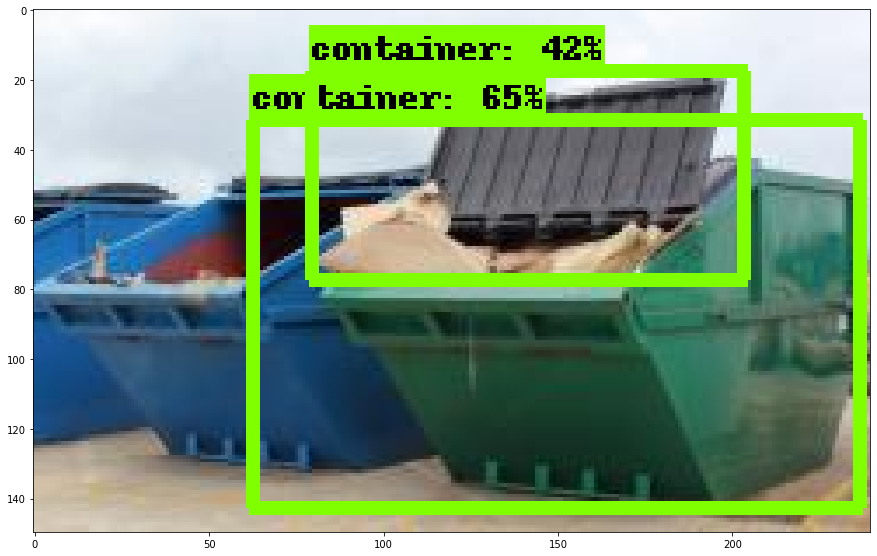

In [47]:
def show_img(img, detector, threshold=0.3):
    detector_output = detector(np.expand_dims(img, axis=0))
    detector_output = {key:value.numpy() for key,value in detector_output.items()}
    
    image_np_with_detections = img.copy()

    # Use keypoints if available in detections
    keypoints, keypoint_scores = None, None

    if 'detection_keypoints' in detector_output:
        keypoints = detector_output['detection_keypoints'][0]
        keypoint_scores = detector_output['detection_keypoint_scores'][0]

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detector_output['detection_boxes'][0],
          (detector_output['detection_classes'][0]+0).astype(int),
          detector_output['detection_scores'][0],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=50,
          min_score_thresh=threshold,
          agnostic_mode=False)
    
    plt.figure(figsize=(15,15))
    plt.imshow(image_np_with_detections)
    plt.show()
    
show_img(img, detect, threshold=0.4)

* **(k)** Tester votre modèles sur d'autres images

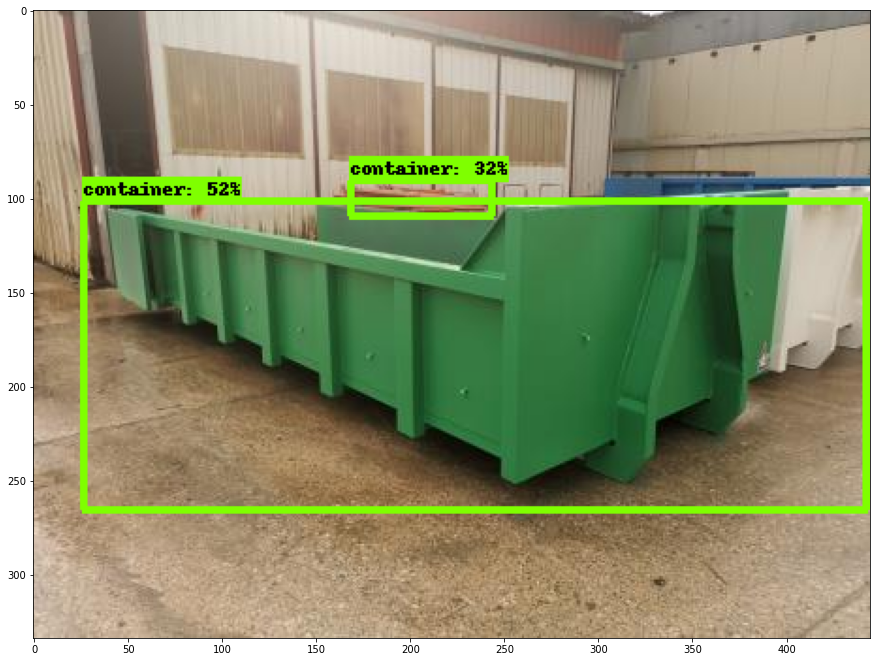

In [48]:
import cv2, urllib

def url_to_image(url):
    resp = urllib.request.urlopen(url) 
    img = np.asarray(bytearray(resp.read()), dtype="uint8")
    img = cv2.imdecode(img, -1)
    img = img[..., [2,1,0]]
    return img

img2 = url_to_image("https://www.direct-benne.com/images/23-benne-gravats.jpg")
show_img(img2, detect, threshold=0.3)

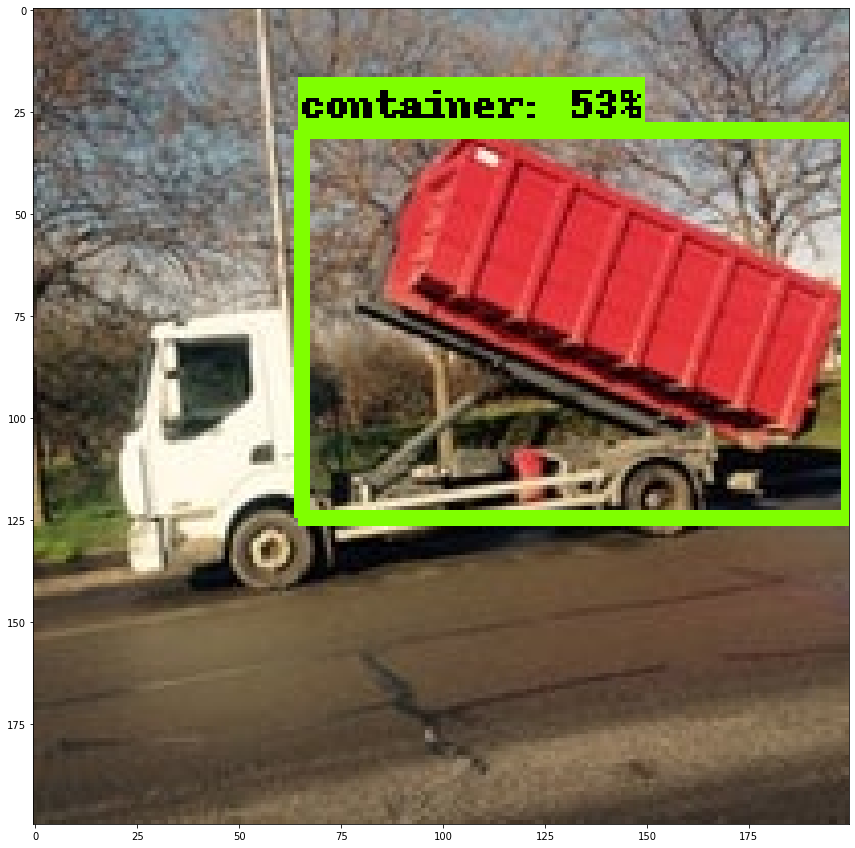

In [49]:
img2 = url_to_image("https://fastly.4sqi.net/img/general/200x200/391271571_KBAx-taHFDmcdsPsfPUAwwuY1tSkCKz3Fs374YBiNfs.jpg")
show_img(img2, detect, threshold=0.5)